In [1]:
import numpy as np
# Train a model to classify real pulses vs. noise
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import awkward as ak
from tensorflow.keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
num_events = 50000
num_samples = 10
xmin = 1
xmax = 10

In [3]:
def plot_timesamples(ax, time, emsignal_list, noisedata_list):
    #fig, ax = plt.subplots()
    for i, emsignal in enumerate(emsignal_list):
        noisedata = noisedata_list[i][1:]
        ax.plot(time, emsignal[1:], label=f'EM pulse' if i==1 else None, color='blue')
        ax.plot(time, noisedata, label=f'noise'  if i==1 else None,color='orange')
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Amplitude (arb. units)')
    ax.legend()

[[ 0.06895913  0.1056133  -0.09143379 ... -0.42161528 -0.29712962
  -0.58216445]
 [ 0.34485138 -0.08731802  0.06661344 ...  0.77302449  0.04550623
   0.00307311]
 [ 0.1237994   0.15758994  0.23702709 ...  0.74946809  0.89637208
   1.        ]
 ...
 [-0.03092482  0.05597267  0.02970392 ...  0.63602553  0.47977004
   0.197776  ]
 [-0.07213616  0.50158804  0.37323287 ...  0.94731449  1.
   0.95559548]
 [ 0.093267   -0.1169253  -0.21280756 ...  0.9604724   1.
   0.49827842]]
Printing y_real
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


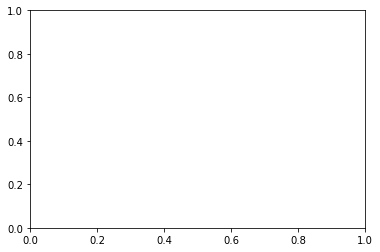

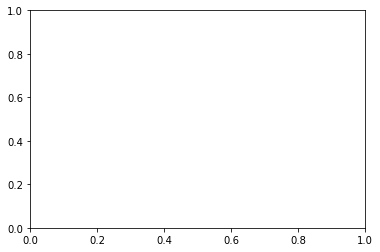

In [5]:
import uproot
### Energy = 0.15 GeV
dirName = "noise_0p15/0p15GeV/"
root_file = uproot.open(f"/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/data/outputPSWithPU_withNoise_0.150000_0.15_v10.root")
tree = root_file["Samples"]
arrays = tree.arrays(["samples", "ysamples","samplesNoise","ysamplesNoise"])
X_real = ak.to_numpy(arrays["samples"])
y_real = ak.to_numpy(arrays["ysamples"])
X_noise = ak.to_numpy(arrays["samplesNoise"])
y_noise = ak.to_numpy(arrays["ysamplesNoise"])

print(X_real) 
print("Printing y_real")
print(y_real)

data = np.concatenate([X_real, X_noise]) ### makes it [2*num_events,num_samples]
labels = np.concatenate([y_real,y_noise])

# Shuffle data and labels together
## Important to shuffle since I take some fraction of events so it should not happen that all the real events 
## are cluttered at the beginning
shuffle_indices = np.random.permutation(len(data))
data = data[shuffle_indices]
labels = labels[shuffle_indices]

fig, ax = plt.subplots()
import awkward as ak

num_events = ak.num(X_real, axis=0)
t_events = np.zeros((num_events, num_samples))
for i in range(num_events):
    t_event = np.linspace(xmin, xmax, 10)
    t_events[i] = t_event
###replace this block with actual time variable

fig, ax = plt.subplots()
#ev_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9 , 10, 100, 200, 300]# list of event numbers to plot
ev_numbers = [1000]
emsignal_list = [X_real[ev_number] for ev_number in ev_numbers]
noisedata_list = [X_noise[ev_number] for ev_number in ev_numbers]
#plot_timesamples(ax, t_events[ev_numbers[0]], emsignal_list, noisedata_list)
#plt.show()

In [6]:
import awkward as ak

num_events_data = ak.num(data, axis=0)
print(f'number of rows in data is {num_events_data}')


ntimeSamples_data = ak.num(data, axis=1)
print(f'number of rows in data is {ntimeSamples_data[0]}') ## just take the 0th event

# Split into train and test sets
train_size = int(0.8 * num_events_data) ###times 2 because the noise is also in the same dataset, so it is 2*num_events
train_data = data[:train_size]
train_labels = labels[:train_size]
test_data = data[train_size:]
test_labels = labels[train_size:]

print(f'Size of training data is {train_size}')

'''
print(train_size)
print(train_data)
print(test_data)
'''

print(f'number of elements in data : training data : test data : {len(data)} : {len(train_data)} : {len(test_data)}')

number of rows in data is 400000
number of rows in data is 10
Size of training data is 320000
number of elements in data : training data : test data : 400000 : 320000 : 80000


In [7]:
x_train = train_data
y_train = train_labels
#n_classes = len(np.unique(y_train))
x_test = test_data
y_test = test_labels

In [8]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [9]:
y_train = y_train.reshape((y_train.shape[0],1))
y_test = y_test.reshape((y_test.shape[0],1))

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

In [11]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [12]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

In [13]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=10,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128,50],
    mlp_dropout=0.4,
    dropout=0.25,
)

#model.compile(
#    loss="sparse_categorical_crossentropy",
#    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
#    metrics=["sparse_categorical_accuracy"],
#)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
)

# Save the model to a file
model.save('/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/model/timeSeries_TransformerNetorkmodel_v10.h5')
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 10, 1)       2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 10, 1)       17921       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

 mbda)                                                            'tf.__operators__.add_5[0][0]'] 
                                                                                                  
 layer_normalization_7 (LayerNo  (None, 10, 1)       2           ['tf.__operators__.add_6[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv1d_6 (Conv1D)              (None, 10, 4)        8           ['layer_normalization_7[0][0]']  
                                                                                                  
 dropout_7 (Dropout)            (None, 10, 4)        0           ['conv1d_6[0][0]']               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 10, 1)        5           ['dropout_7[0][0]']              
          

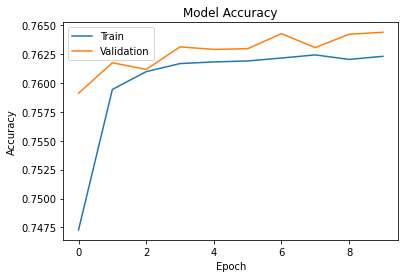

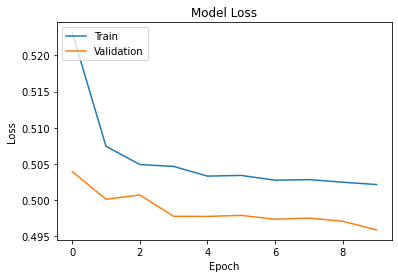

In [24]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

80000 and 80000
 predictions are [0.49473312 0.10345319 0.40843076 ... 0.08908918 0.04959143 0.85758513]


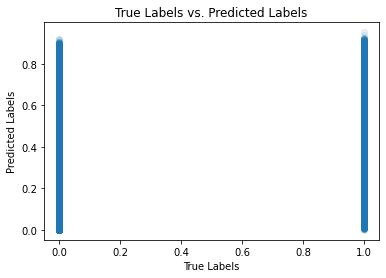

In [25]:
# Make predictions on test data
predictions = model.predict(x_test).flatten()
# Convert predictions to binary labels
binary_predictions = (predictions > 0.5).astype(int)

print(f'{len(y_test)} and {len(binary_predictions)}')
print(f" predictions are {predictions}")
# Create scatter plot of true labels vs. predicted labels
plt.scatter(y_test, predictions, alpha=0.1)
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('True Labels vs. Predicted Labels')
plt.show()

test labels are: [0. 0. 0. ... 0. 0. 1.]
[0.49473312 0.10345319 0.40843076 ... 0.8758154  0.08908918 0.04959143]
[0.85750854 0.40211153 0.07119758 ... 0.76024705 0.79366505 0.85758513]


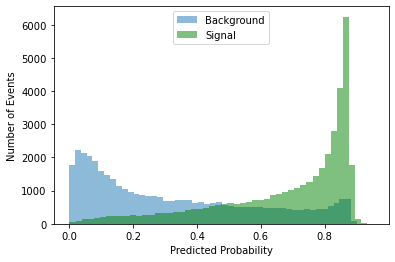

In [26]:

print(f'test labels are: {y_test[:,0]}')

# Create separate arrays for background and signal predictions
bkg_preds = predictions[y_test[:,0] == 0]
sig_preds = predictions[y_test[:,0] == 1]

print(bkg_preds)
print(sig_preds)
# Plot the predicted probabilities
plt.hist(bkg_preds, bins=50, label='Background', alpha=0.5)
plt.hist(sig_preds, bins=50, label='Signal', alpha=0.5, color='green')
plt.xlabel('Predicted Probability')
plt.ylabel('Number of Events')
plt.legend(loc='upper center')
#plt.ylim(top=100)
#plt.show()
plt.savefig("bkgVsSig_v1.png")

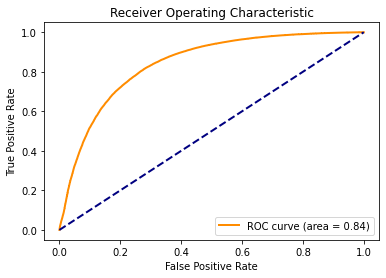

In [27]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.xlim([0.9, 1])
#plt.ylim([0.999, 1.005])
#plt.show()
plt.savefig("ROC_v1.png")

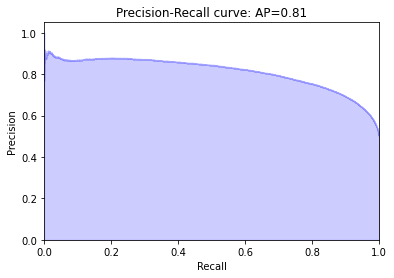

In [28]:
### precision recall curve
# Calculate precision-recall curve and average precision
precision, recall, _ = precision_recall_curve(y_test, predictions)
average_precision = average_precision_score(y_test, predictions)

# Plot precision-recall curve
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()